In [29]:
from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile
)

from operator import attrgetter
from datetime import datetime, timedelta

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
# Parameters

##### release position 
release_zone = "test_001"
bathymodiolus_delta_lat = 0.08  #change??

release_depth = 200

# release particles
number_particles = 100

# release timing
release_time_in_days = 1   # e.g. from 01/01/2009 to 03/01/2009 
start_year = 2009
start_month = 1
start_day = 1

# experiment duration etc
runtime_in_days = 5
dt_in_minutes = 60

# particle positions are stored every x hours 
outputdt_in_hours = 24

# release location file
release_locations_file = "../data/config/test_stations.csv"

# location of input data
data_path = '../data/config/'#'/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'ROMS' 
data_resolution = '1d'

# names of files to load
fname = 'roms_avg01_2009_datetime.nc'
depthfile = 'sigma2depth_parent.nc'
meshfile = 'roms_grd2_1500mVT1.nc'

# location of output data
outpath = f'../output_data/{experiment_name}'
output_filename = '{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'

# how to initialize the random number generator
RNG_seed = 12345


In [3]:
# remove spaces and lower the input from csv file
release_zone = release_zone.lower().replace(' ', '-').replace("'", '-')

# correct runtime
corrected_runtime_in_days = runtime_in_days + release_time_in_days

### Construct input / output paths etc.

In [4]:
data_path = Path(data_path)
mesh_path = data_path
depth_path = data_path
#mesh_mask = mask_path / experiment_name / fname

outpath = Path(outpath)

output_filename = output_filename.format(
    release_zone = release_zone,
    RNG_seed=RNG_seed,
    start_year=start_year,
    start_month = start_month,
    start_day = start_day,
    runtime_in_days = runtime_in_days,
    number_particles=number_particles
)
outfile = outpath / output_filename
outfile

PosixPath('../output_data/ROMS/test_001_20090101_RT-5_N-100_seed-12345.nc')

### Load release location

In [5]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [6]:
release_locations = load_release_locations(release_locations_file)
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]
bathymodiolus_delta_lon = bathymodiolus_delta_lat * np.cos(np.deg2rad(bathymodiolus_lat))

bathymodiolus_lat, bathymodiolus_lon, release_depth

(-23.25, 8.25, 200.0)

### Fieldset

In [7]:
def fieldset_definitions(
    data_file, mesh_file, depth_file 
):
    
    filenames = {'U': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'V': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'W': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'T': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                }

    variables = {'U': 'u',
                 'V': 'v',
                 'W': 'w',
                 'T': 'temp'
                }
    
    dimensions = {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'hs', 'time': 'time'}
    
    #dimensions = {'U': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'hs',
    #                   'time': 'time'},  # needs to be on f-nodes
    #              'V': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'hs',
    #                    'time': 'time'},  # needs to be on f-nodes
    #              'W': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'hs',
    #                    'time': 'time'},  # needs to be on f-nodes
    #              'T': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'hs',
    #                    'time': 'time'},  # needs to be on t-nodes
    #             }  

    return FieldSet.from_nemo(
        filenames, variables, dimensions,
        chunksize=False,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer',
        allow_time_extrapolation=True
    )

In [8]:
def create_fieldset(
    data_path=data_path, mesh_path=mesh_path, depth_path=depth_path, experiment_name=experiment_name,
    fname=fname, meshfile=meshfile, depthfile=depthfile
):
    
    data = list(sorted((data_path / experiment_name).glob(fname)))
    mesh = list(sorted((mesh_path / experiment_name).glob(meshfile)))
    depth = list(sorted((depth_path / experiment_name).glob(depthfile)))
    
    fieldset = fieldset_definitions(
        data, mesh, depth)
    return fieldset

In [9]:
fieldset = create_fieldset()

In [10]:
print(type(fieldset.U.grid))
assert fieldset.U.grid is fieldset.V.grid
assert fieldset.U.grid is fieldset.W.grid

<class 'parcels.grid.RectilinearSGrid'>


In [11]:
fieldset.computeTimeChunk(time=fieldset.U.grid.time[0], dt=1)
print(fieldset.U.data.shape)
print(fieldset.U.grid.lon.shape)
print(fieldset.U.grid.lat.shape)
print(fieldset.U.grid.depth.shape)

(2, 32, 257, 237)
(237,)
(257,)
(32, 257, 237)


In [12]:
print(fieldset.U.grid.depth[:,0,0])

[1681.8895   1667.2445   1649.4756   1628.0054   1602.1926   1571.3462
 1534.751    1491.7078   1441.5907   1383.9218   1318.4575   1245.2798
 1164.8749   1078.1821    986.5929    891.8883    796.1139    701.4093
  609.82007   523.12726   442.72235   369.54465   304.0804    246.4115
  196.29445   153.25117   116.65596    85.80959    59.99679    38.526546
   20.757671    6.112674]


### Create a set of particles with random initial positions

In [13]:
np.random.seed(RNG_seed)

time = np.sort(
        datetime(start_year, start_month, start_day)
        + timedelta(hours=1) * np.random.randint(
            0, (release_time_in_days) * 24 * 60 / dt_in_minutes, size=(number_particles, )
        )
)

######
lat = np.random.normal(
    loc=bathymodiolus_lat, scale=bathymodiolus_delta_lat,
    size=time.shape
)

lon = np.random.normal(
    loc=bathymodiolus_lon, scale=bathymodiolus_delta_lon,
    size=time.shape
)

depth = np.ones(time.size) * release_depth 

speed_param = np.random.uniform(
    low=0, high=1.0, size=time.shape
)

In [14]:
print(time[:5])

[datetime.datetime(2009, 1, 1, 0, 0) datetime.datetime(2009, 1, 1, 0, 0)
 datetime.datetime(2009, 1, 1, 0, 0) datetime.datetime(2009, 1, 1, 0, 0)
 datetime.datetime(2009, 1, 1, 0, 0)]


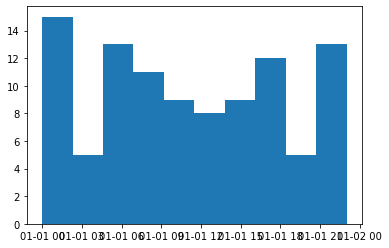

In [15]:
plt.hist(time, bins=10);

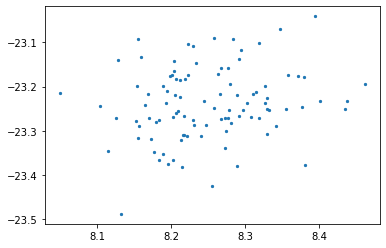

In [16]:
plt.scatter(lon, lat, s=5);

In [17]:
fieldset.U.grid.time_full = fieldset.U.grid.time_full.astype(np.float64)
# This next line shouldn't be necessary. But there was a bug at some time apparently

In [18]:
%%time
pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle, #SampleParticle später? muss dann vorher auch def werden,
    lat=lat,
    lon=lon,
    depth=depth,
    time=time
)
print(pset[0])

P[0](lon=8.169476, lat=-23.217178, depth=200.000000, time=0.000000)
CPU times: user 42.5 ms, sys: 55.3 ms, total: 97.7 ms
Wall time: 46 ms


In [19]:
kernel = pset.Kernel(AdvectionRK4_3D)

### Be able to handle errors during integration

In [20]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
recovery_cases = {
        ErrorCode.ErrorOutOfBounds: DeleteParticle
    }

In [21]:
outfile

PosixPath('../output_data/ROMS/test_001_20090101_RT-5_N-100_seed-12345.nc')

In [22]:
output_pfile = pset.ParticleFile(name=outfile, outputdt=timedelta(hours=outputdt_in_hours))

In [23]:
pset.execute(
    kernel,
    runtime=timedelta(days=corrected_runtime_in_days),
    dt=timedelta(minutes=dt_in_minutes),
    output_file=output_pfile,
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-1001/lib8b0434235702749bd8e67c6b3a44f9e8_0.so


### Errors at bottom:
* Particle P[23](lon=8.339165, lat=-23.223385, depth=936.193193, time=216000.000000)
  
  Time: 2009-01-03T12:00:00.000000000,	timestep dt: 3600.000000
  
  Through-surface sampling by particle at (8.339165, -23.223385, 936.193193)

### Errors at surface:
* Particle P[4](lon=8.254837, lat=-23.426231, depth=10.000000, time=0.000000)
   
  Time: 2009-01-01T00:00:00.000000000,	timestep dt: 3600.000000
  
  Out-of-bounds sampling by particle at (8.254837, -23.426231, 10.000000)

In [24]:
output_pfile.export()

/home/lmock/anaconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [25]:
particle_ds = xr.open_dataset(outfile)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100, obs: 7)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical

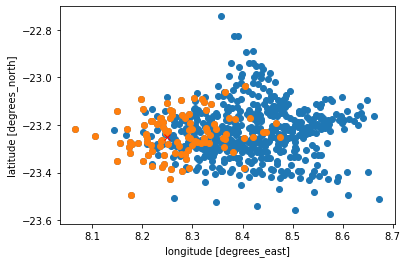

In [26]:
particle_ds.plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

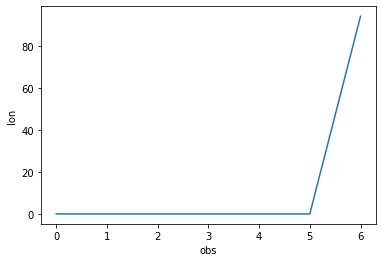

In [27]:
particle_ds.lon.isnull().sum("traj").plot()